In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 11a

## Adam Optimizer


<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com">

<img src='../../images/adam_algorithm.jpg' style='width: 800px' alt="Adam Algorithm" >

In [2]:
###-----------------
### Import Libraries
###-----------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)

# Parameters for plotting
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

In [4]:
# Take any function of second order
def fn_sin(x, y):
    return 2* np.square(x) + 2 * np.sin(np.pi*x) + 2* np.square(y) + 4 * np.sin(np.pi*y)


# Calculate the gradient
def grad_fn_sin(x, y):
    return np.asarray([4 * x + 2 *np.pi* np.cos(np.pi*x), 4 * y + 4 * np.pi *np.cos(np.pi*y)])

In [5]:
# Take any function of second order
def fn_cos(x, y):
    return 2* np.square(x) + 2 * np.cos(np.pi*x) + 2* np.square(y) + 4 * np.cos(np.pi*y)


# Calculate the gradient
def grad_fn_cos(x, y):
    return np.asarray([4 * x - 2 *np.pi* np.sin(np.pi*x), 4 * y - 4 * np.pi *np.sin(np.pi*y)])


In [6]:
def adam(x, func, grad_func, bounds, max_iter, alpha = 0.01, beta1=0.9, beta2=0.999, eps=1e-8):
    
    # Gradient descent algorithm with adam    
    theta, costs, grad_costs = [], [], []
    t = 0
    old_x= x.copy() # add initial point
    theta.append( x.copy() )
    costs.append( func(x[0], x[1]) )

    # initialize first and second moments
    m = [0.0 for _ in range(bounds.shape[0])]
    v = [0.0 for _ in range(bounds.shape[0])]

    while (True):    

        t+=1

        # calculate gradient g(t)
        g = grad_func(x[0], x[1])

        for i in range(bounds.shape[0]):

            # m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]

            # v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2

            # m_cap(t) = m(t) / (1 - beta1(t))
            m_cap = m[i] / (1.0 - beta1**(t+1))

            # vhat(t) = v(t) / (1 - beta2(t))
            v_cap = v[i] / (1.0 - beta2**(t+1))

            # theta_0 = theta_0 - ( alpha * m_cap ) / ( np.sqrt( v_cap ) + epsilon )    #updates the parameters
            x[i] = x[i] - alpha * m_cap / (np.sqrt(v_cap) + eps)


        dist = np.linalg.norm ( x - old_x )
        old_x = x.copy() # update old x

        theta.append( x.copy() )

        costs.append( func(x[0], x[1]) )

        grad_costs.append( grad_func(x[0], x[1]) )

        if(dist <= 1e-5):   #checks if it is converged or not
            #print ('Convergence at Iteration:{:d},  Theta : {:.2f} {:.2f}'.format( t, x[0], x[1]) )
            break

        if(t > max_iter):   #checks if it is converged or not
            print ('No Convergence till : {}'.format(t))
            break
    
    return costs, theta

In [7]:
def fn_plot_base(bound, func, fig):

    # sample input range uniformly at 0.1 increments
    xaxis = np.arange(bound[0,0], bound[0,1], 0.01)
    yaxis = np.arange(bound[1,0], bound[1,1], 0.01)


    # create a mesh from the axis
    x, y = np.meshgrid(xaxis, yaxis)

    # compute targets
    results = func(x, y)
    
    #===============
    #  First subplot
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    # create a surface plot with the jet color scheme
    ax.plot_surface(x, y, results, cmap='jet', zorder=0)
    
    #===============
    #  Second subplot
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 2, 2)
    
    # create a filled contour plot with 50 levels and jet color scheme
    ax.contourf(x, y, results, levels=50, cmap='jet', zorder=0)

In [8]:
def fn_plot_results(axes, score, line):
    offset = 0.02
    
    xyz_line = np.hstack((np.asarray(line), np.asarray(score).reshape(-1,1) ))
    
    axes[0].plot(xyz_line[:,0], xyz_line[:,1], xyz_line[:,2], '-',
                 linewidth = 1, color='w', zorder=5, alpha = 0.9)
    

    # plot the line bwing tracked
    axes[1].plot(xyz_line[:, 0], xyz_line[:, 1], 
                 '.-', color='w', zorder=10)

    # next plot starting point and its text
    axes[1].scatter(xyz_line[0, 0], xyz_line[0, 1], 
                    s=80, c='k', marker=(5, 2), zorder=20)
    
    axes[1].text(xyz_line[0, 0] + offset , xyz_line[0, 1] + offset, 
                 '({:.1f},{:.1f})'.format(xyz_line[0, 0], xyz_line[0, 1]),
                 fontsize=10, zorder=20)
    
    # plot end point
    axes[1].scatter(xyz_line[-1, 0], xyz_line[-1, 1], s=80, c='r', marker=(5, 2), zorder=20)
    #axes[1].text(xyz_line[-1, 0] + 0.05, xyz_line[-1, 1] + 0.05, '({:.2f},{:.2f})'.format(xyz_line[0, 0], xyz_line[0, 1]), fontsize=15, zorder=20)


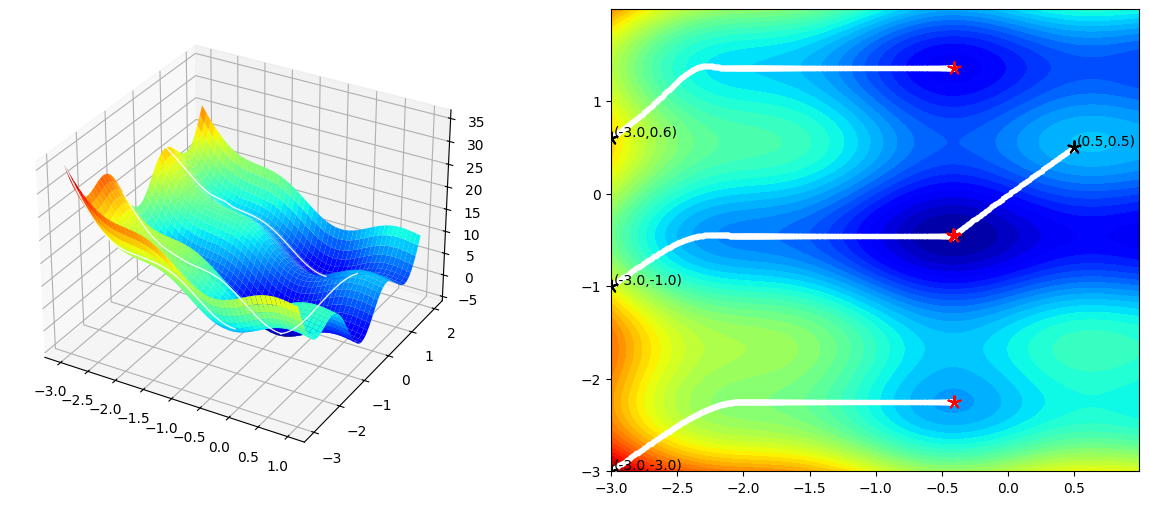

In [9]:
# seed the pseudo random number generator
np.random.seed(RANDOM_STATE)

# define range for input
bounds = np.asarray([[-3.0, 1.0], [-3.0, 2.0]])

# define the total iterations
n_iter = 60

# steps size
alpha = 0.01

# factor for average gradient
beta1 = 0.9

# factor for average squared gradient
beta2 = 0.999

# Epsilon
epsilon = 1e-8

x_list = []

# Generate an initial point
#x_list.append( bounds[:, 0] + np.random.rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0]) / 2 )
x_list.append( np.asarray([-3.0, -3.0]) )
x_list.append( np.asarray([-3.0, -1.0]) )
x_list.append( np.asarray([0.5, 0.5]) )
x_list.append( np.asarray([-3.0, 0.6]) )


# set up a figure twice as wide as it is tall
fig = plt.figure()
fn_plot_base(bounds, fn_sin, fig)

for x in x_list:
    costs, theta = adam(x, fn_sin, grad_fn_sin, bounds, 500)
    fn_plot_results(fig.get_axes(), costs, theta)

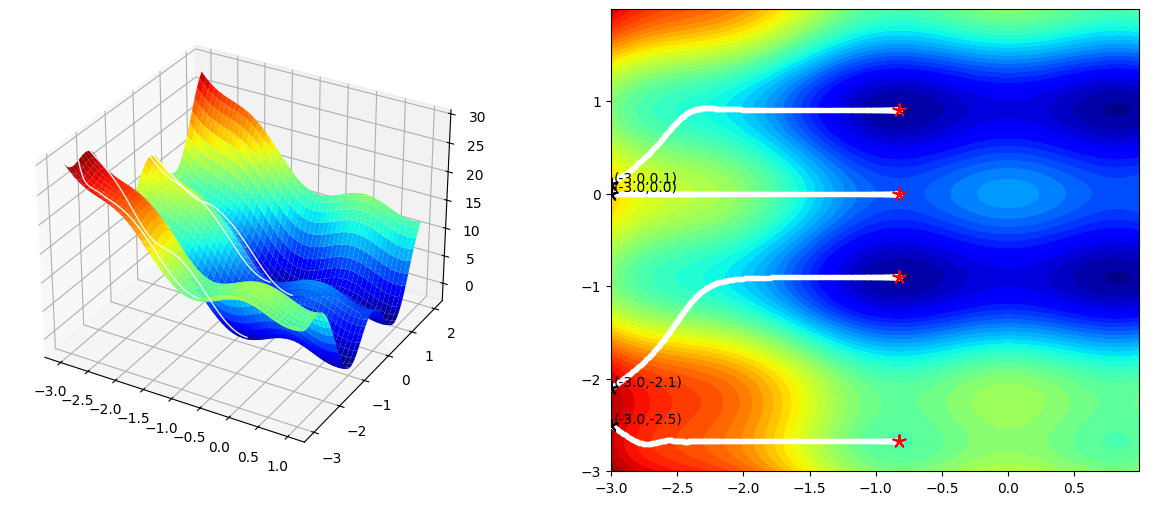

In [10]:
x_list = []

# Generate an initial point
#x_list.append( bounds[:, 0] + np.random.rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0]) / 2 )
x_list.append( np.asarray([-3.0, -2.5]) )
x_list.append( np.asarray([-3.0, -2.1]) )
x_list.append( np.asarray([-3.0,  0.0]) )
x_list.append( np.asarray([-3.0, 0.1]) )

# set up a figure twice as wide as it is tall
fig = plt.figure()
fn_plot_base(bounds, fn_cos, fig)

for x in x_list:
    costs, theta = adam(x, fn_cos, grad_fn_cos, bounds, 500)
    fn_plot_results(fig.get_axes(), costs, theta)